In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv
import numpy as np
import scipy.special as special
from time import time

'TEST(\n    kvec=[1],\n    k_ind=0,\n    z=700,\n    mv_test=1,\n    Omega_M=0.95,\n    Omega_b=0.05,\n    PLOT_FIGUR=True,)'

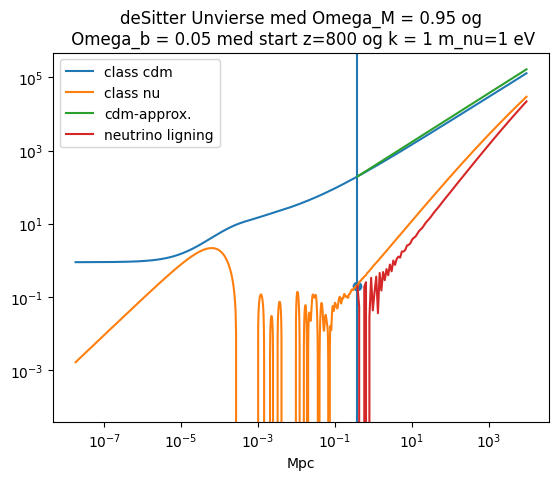

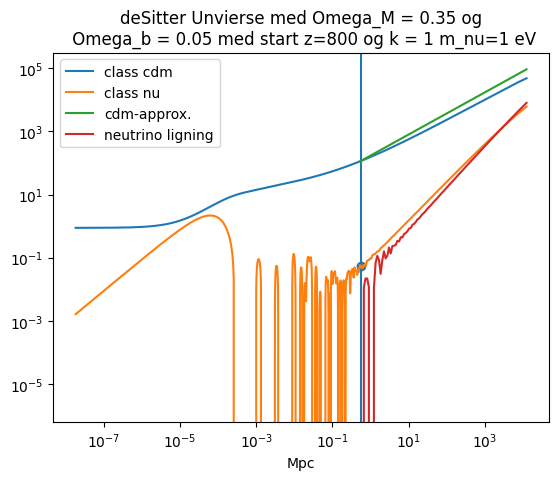

In [20]:
def TEST(kvec=[1],k_ind=0,z=600,mv_test=1 ,   Omega_M = 0.95,Omega_b=0.05,PLOT_FIGUR=True,wack=False):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv


    # henter class data
    #=======================
    delta_class = pts[k_ind]["delta_cdm"]
    #theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
    a_class = pts[k_ind]["a"]
    #=======================

    # interpolation af class data
    # ==============================
    tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
    interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
    interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class)
    delta_init = scipy.interpolate.interp1d(tau_class,delta_class)
    delta_tid = scipy.interpolate.interp1d(tid_class,delta_class)

    neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
    theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
    neu_interp = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
    #a_interp = scipy.interpolate.interp1d(tau_class,a_class)
    #a_interp_tid = scipy.interpolate.interp1d(a_class,tid_class)
    # ===============================

        # valg af z-start værdi
    # ===============================
    a0 = 1/(1+z)
    a_span = [a0,1]
    # ===============================
    # danner start værdier for conformal og fysisk tid og delta_cdm
    # ===============================
    T_ini = float(interp_tau_from_a(a0))
    T_ini_tid = float(interp_tid_from_a(a0))
    T_0 =  float(T_ini_tid)
    delta0 = delta_init(T_ini)
    # ===============================


    # Jeg har skreve cs(a) som c/a i mathmatica så vi definere først c som konstant
    # ===============================
    c = cs(1)
    # ===============================

    # diff ligning i fysisk tid
    # ===============================
    t0 = tid[-1]

    #y0 = np.array([neu_interp(a0),0])
    t = [T_0,tid[-1]]
    a0 = ((T_0)/tid[-1])**(2/3)
    #sol = scipy.integrate.solve_ivp(func,t,y0,args=(a0,))
    # ===============================

    
    t = np.logspace(np.log10(T_0),np.log10(tid[-1]),100)


    def f2(t):
        C1 = np.sqrt(neu_tid(T_0)**2 + (theta_neu_tid(T_0)*a0/ (cs(a0)*k))**2)
        C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
               
        a = (t/t0)**(2/3)
        val = 3 * cs(a) * k * t0 * np.sqrt(a)        
        if wack==True:
            dcdm = delta0/(a0 **(0.95))
            D = dcdm * a**(0.95)
        else:
            dcdm = delta0/a0 
            D = a*dcdm
        return D+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
    
    if PLOT_FIGUR==True:
        
        plt.figure(np.random.randint(1,1000))
        plt.axvline(T_0 )
        plt.loglog(tid_class,-delta_class,label="class cdm")
        plt.plot(tid_class,-delta_neutrino_class,label="class nu")

        #plt.plot(sol.t,-sol.y[0],label="sim nu")
        plt.xlabel("Mpc")
        plt.scatter(T_ini_tid,-neu_interp(a0))
        plt.loglog(t,-delta0/a0*Power(t/t0,2/3),label="cdm-approx.")
        plt.loglog(t,-f2(t),label="neutrino ligning")
        # den er her hvis man lige skal overbevise sigselv om hvorfor man ikke skal bruge ligningen før z
        #plt.loglog(tid_class,-f2(tid_class),label="neutrino ligning-2")
        
        plt.legend()
        
        plt.title("deSitter Unvierse med Omega_M = %s og\n Omega_b = %s med start z=%s og k = %s m_nu=%s eV" %(Omega_M,Omega_b,z,k,mv_test))
        #plt.savefig("deSitter Unvierse med Omega_M = %s og Omega_b = %s med start z=%s og k = %s m_nu=%s eV.png" %(Omega_M,Omega_b,z,k,mv_test))

    return f2(t0)

t1 = time()
"""for i in np.logspace(-2,1,1):
    s = TEST(kvec=[i],k_ind=0,z=600,mv_test=1,Omega_M = 0.3,PLOT_FIGUR=True)
t2 = time()
print(s)
print(t2-t1)
"""
TEST(
    kvec=[1],
    k_ind=0,
    z=800,
    mv_test=1,
    Omega_M=0.95,
    Omega_b=0.05,
    PLOT_FIGUR=True,)
TEST(
    kvec=[1],
    k_ind=0,
    z=800,
    mv_test=1,
    Omega_M=0.35,
    Omega_b=0.05,
    PLOT_FIGUR=True,)


"""TEST(
    kvec=[1],
    k_ind=0,
    z=700,
    mv_test=1,
    Omega_M=0.95,
    Omega_b=0.05,
    PLOT_FIGUR=True,)"""
#plt.title("deSitter Unvierse med Omega_M = %s og Omega_b = %s med start z=%s og k = %s" %(0.95,0.05,700,1))

#plt.savefig("test")

-977.1802918238498

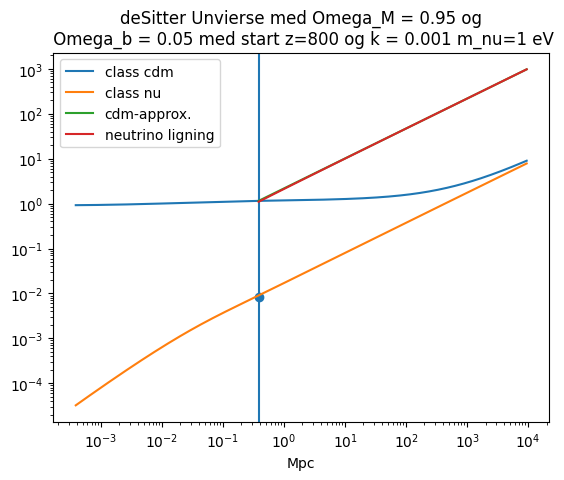

In [30]:

TEST(
    kvec=[1e-3],
    k_ind=0,
    z=800,
    mv_test=1,
    Omega_M=0.95)

-2.8543777465820312

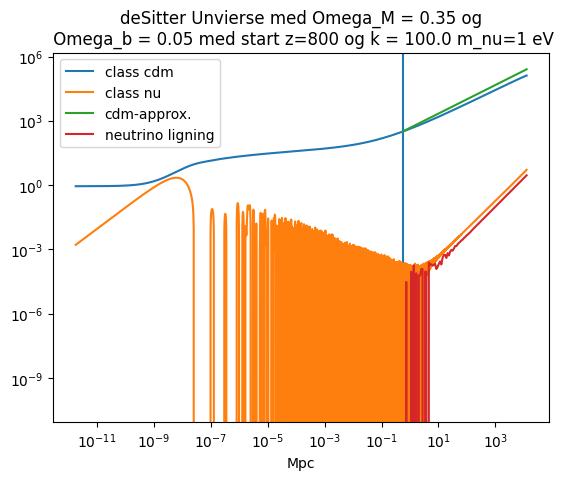

In [22]:

TEST(
    kvec=[1e2],
    k_ind=0,
    z=800,
    mv_test=1,
    Omega_M=0.35,
    Omega_b=0.05,
    PLOT_FIGUR=True,)

-7008.231030170806

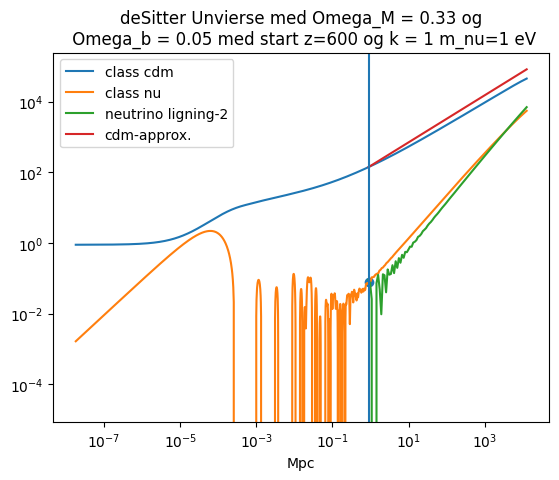

In [3]:
TEST(kvec=[1],k_ind=0,z=600,mv_test=1,Omega_M = 0.33,Omega_b=0.05)
#plt.title("deSitter Unvierse med Omega_M = %s og Omega_b = %s" %(0.33,0.005))

-105131.9074850374

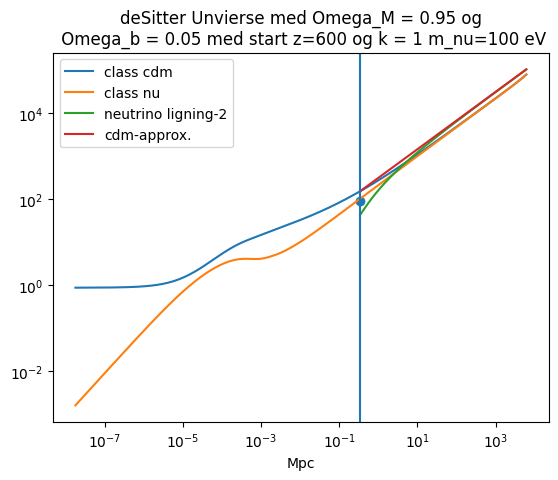

In [4]:

TEST(kvec=[1],k_ind=0,z=600,mv_test=100,Omega_M = 0.95)
#plt.title("neutrino mass = 100 eV")

-312.1678876876831

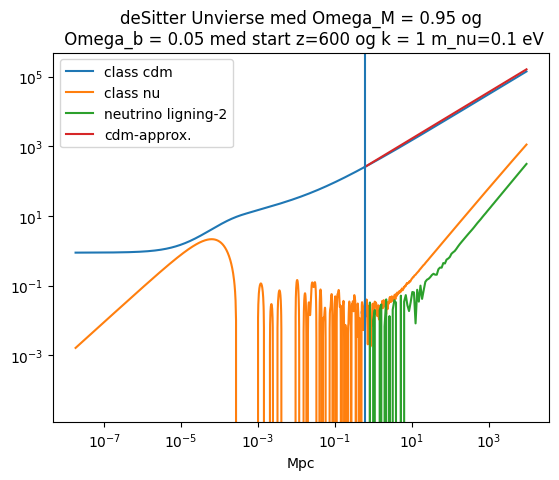

In [5]:
TEST(kvec=[1],k_ind=0,z=600,mv_test=0.1)
#plt.title("neutrino mass = 0.1 eV")

Vi starter i $t_s$ og slutter i $t_0$ (idag)

$\ddot{\delta} +2 H \dot{\delta} + \frac{c_s ^2 k^2}{a^4}\delta = \frac{3}{2} H^2 \delta_{cdm}$

$\delta_{cdm} = \frac{\delta_{cdm,ts}}{a_s} a$

Hvor $a_s =  \left(\frac{t_s}{t_0}\right) ^{2/3}$

$a = \left(\frac{t}{t_0}\right) ^{2/3}$

$ H = \frac{2}{3} \frac{1}{t}$

i Mathmatica:

$ K1 = \delta_{cdm,ts} / a_s$

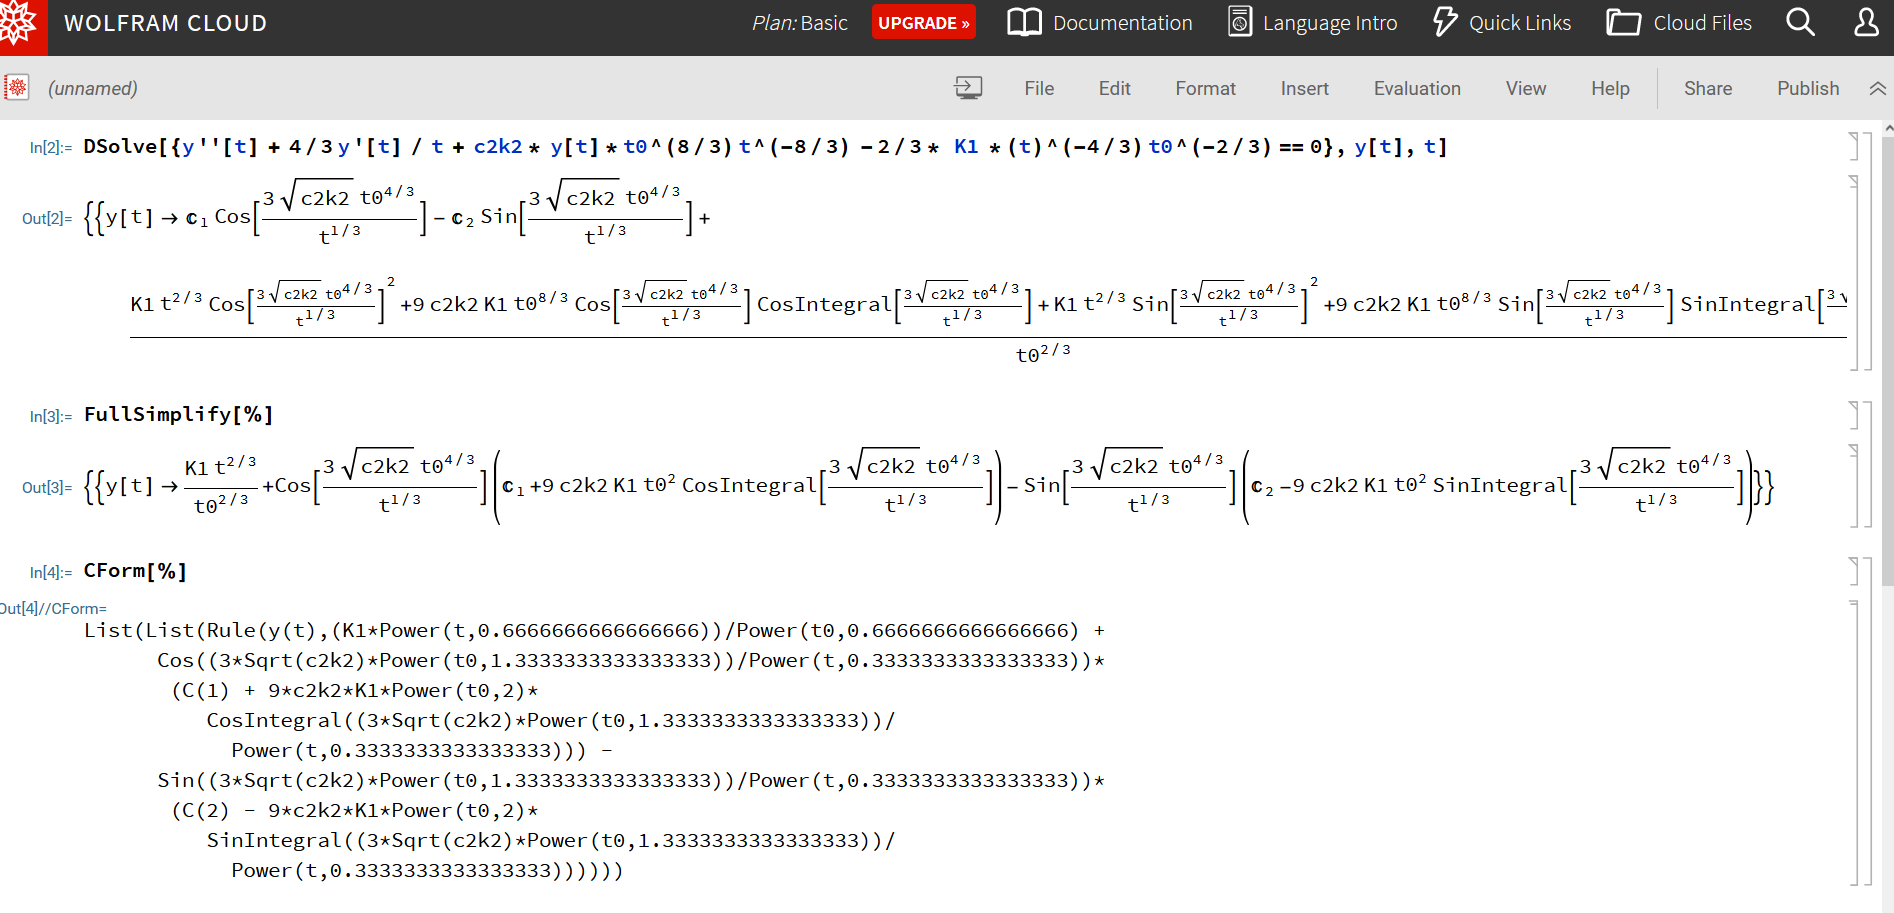

$A = 3 c_s(a=1) k t_0\; B = 3 c_s(a_{ts}) k t_s / a_{ts}$



$S_I A = sinIntegral(A)$

$C_I A = cosIntegral(A)$

$S_I B = sinIntegral(B)$

$C_I B = cosIntegral(B)$

$S_A = sin(A)\; C_A = cos(A) \; S_B = sin(B) \; C_B = cos(B)$

$c_1 = \frac{\delta_{ts}-\delta_{\nu,ts} + \delta(t_s)B^2 C_IB + s_B \delta_{ts} B^2 S_IB - \frac{s_B}{s_A}(\delta(t_0)-\delta_{\nu,t_0} + c_A \delta_{t_0} A^2 C_IA + s_A \delta_{t_0}A^2 S_I A)  }{S_BC_A/S_A - C_B}\;$
$c_2 = \frac{1}{s_A}(\delta_{t_0}-\delta_{\nu,t_0}+c_A \delta_{t_0} A^2 C_IA s_A \delta_{t_0} A^2 S_I A) + \frac{c_A}{s_A}c_1$


$\delta_{\nu} = \delta_{cdm} + \cos(3c_s(a) kt/a) \left(c_1 + \delta_{cdm} (3c_s(a)kt/a)^2cosInt(3c_s(a)kt/a)\right) - \sin(3c_s(a)kt/a)\left(c_2 - \delta_{cdm}(3c_s(a)kt/a)^2SinInt(3c_s(a)kt/a)\right)$


In [42]:
def sim(kvec=[1],k_ind=0,z=600,mv_test=1 ,   Omega_M = 0.95,conf=True):
    # C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,"Omega_b":0.05, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3}

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    # det kommer af Gyrs * c = 306.4 Mpc
    tid = bg['proper time [Gyr]'] * c / 306.4
    pts = cosmo.get_perturbations()['scalar']
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv


    # henter class data
    #=======================
    klist = np.zeros(len(kvec))
    for k_ind,k in enumerate(kvec):
        delta_class = pts[k_ind]["delta_cdm"]
        #theta_class = pts[k_ind]["theta_cdm"]
        tau_class = pts[k_ind]["tau [Mpc]"]
        delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
        theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
        a_class = pts[k_ind]["a"]
        #=======================

        # interpolation af class data
        # ==============================
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class)
        delta_init = scipy.interpolate.interp1d(tau_class,delta_class)
        delta_tid = scipy.interpolate.interp1d(tid_class,delta_class)

        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_interp = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
        #a_interp = scipy.interpolate.interp1d(tau_class,a_class)
        #a_interp_tid = scipy.interpolate.interp1d(a_class,tid_class)
        # ===============================

            # valg af z-start værdi
        # ===============================
        a0 = 1/(1+z)
        a_span = [a0,1]
        # ===============================
        # danner start værdier for conformal og fysisk tid og delta_cdm
        # ===============================
        T_ini = float(interp_tau_from_a(a0))
        T_ini_tid = float(interp_tid_from_a(a0))
        T_0 =  float(T_ini_tid)
        delta0 = delta_init(T_ini)
        # ===============================


        # Jeg har skreve cs(a) som c/a i mathmatica så vi definere først c som konstant
        # ===============================
        c = cs(1)
        # ===============================

        # diff ligning i fysisk tid
        # ===============================
        t0 = tid[-1]

        #y0 = np.array([neu_interp(a0),0])
        t = [T_0,tid[-1]]
        a0 = ((T_0)/tid[-1])**(2/3)
        #sol = scipy.integrate.solve_ivp(func,t,y0,args=(a0,))
        # ===============================


        def f2(t):
            C1 = np.sqrt(neu_tid(T_0)**2 + (theta_neu_tid(T_0)*a0/ (cs(a0)*k))**2)
            C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
            dcdm = delta0/a0        
            a = (t/t0)**(2/3)
            val = 3 * cs(a) * k * t0 * np.sqrt(a)        
            return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
        
        H_slut = (2/3) * 1/t0
        a_slut = 1
        bonus = 0
        if conf==True:
            #print(H_slut,theta_neu_tid(t0),1/k**2,H_slut*theta_neu_tid(t0)/k**2)
            bonus = 3 * a_slut * H_slut * theta_neu_tid(t0)/ k**2 
            print(bonus)
        klist[k_ind] = f2(t0) + bonus
    return klist

t1 = time()
s = sim(kvec=list(np.logspace(-4,1,5)))
t2 = time()
print(s)
print(t2-t1)
print("="*20)

t1 = time()
s = sim(kvec=list(np.logspace(-4,1,5)),conf=False)
t2 = time()
print(s)
print(t2-t1)


-5.145192535086281e-08
-1.6134028103103505e-05
-0.002609717787174351
-0.0066608114615774525
-0.00013343157581536885
[  -724.53808098   -746.66158882  -6049.04272441 -32507.03070437
   -695.5132424 ]
4.215607643127441
[  -724.53808093   -746.66157268  -6049.04011469 -32507.02404356
   -695.51310897]
4.158775568008423


In [35]:
Omega_M = 0.95
Omega_R = 0
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
H0 = 67 / (3*1e5) # i 1/Mpc
mv_test = 1 # eV
kvec = np.logspace(-3,1,30)
h = 0.6704
cosmo_dict ={'h':h,  'Omega_cdm':Omega_M, "Omega_b":0.05,'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3,
             #'gauge':"newtonian"
            }
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()
pts = cosmo.get_perturbations()['scalar']
#print(bg.keys())
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]
mv = mv_test * 1e-6
tranf = cosmo.get_transfer(z=0)
#print(tranf.keys())
prim = cosmo.get_primordial()
#print(prim.keys())

k = tranf['k (h/Mpc)'] * h
#plt.loglog(tranf['k (h/Mpc)'],-tranf["d_ncdm[0]"])

prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")


In [36]:
#print(k)

In [43]:
test = sim(kvec=list(kvec))


-5.130620127958162e-06
-9.660572236991452e-06
-1.8156968110041165e-05
-3.402009679206678e-05
-6.341218325336009e-05
-0.00011719698102285896
-0.00021370244074011348
-0.00038190578712364413
-0.0006640186212066438
-0.0011157535333935096
-0.0017965428777578878
-0.002743066451650253
-0.003962914172974718
-0.005449953825825665
-0.006973492025245457
-0.008300230413252743
-0.00917301012841478
-0.009437432255485736
-0.009002875752412725
-0.007966986085261701
-0.006567743104060717
-0.005065255589406094
-0.003676891615713914
-0.002530173603807757
-0.0016635813758538722
-0.0010535342261279183
-0.0006475032649414286
-0.00038877567056878545
-0.00022930226996600397
-0.00013343157581536885


In [38]:
print(test)

[  -731.50174975   -737.73524808   -749.47490996   -771.59392833
   -813.25357749   -891.42331149  -1037.30750934  -1306.82840587
  -1796.12577457  -2658.18200899  -4107.29991607  -6387.23281492
  -9699.8867139  -14149.41459937 -19686.79821764 -25790.40449785
 -31596.74336602 -35929.23757758 -37709.224733   -36373.90101928
 -32177.25992359 -26134.04331854 -19587.81787346 -13674.78768422
  -9002.19682245  -5664.25643873  -3448.69199846  -2051.93656126
  -1201.47153205   -695.5132424 ]


Text(0.5, 1.0, 'neutrino power sepctrum for a neutrino of mass 1 eV')

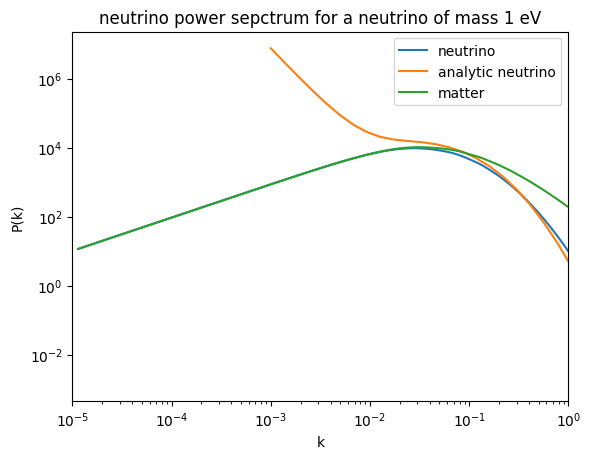

In [39]:

plt.figure(1)
plt.loglog(k, 2*np.pi**2 * tranf["d_ncdm[0]"]**2* k**(-3) * prim_interp(k) * h**3,label="neutrino")
plt.loglog(kvec, 2*np.pi**2 * test**2 * kvec**(-3) * prim_interp(kvec) * h**3,label="analytic neutrino")
plt.loglog(k, 2*np.pi**2 * tranf["d_cdm"]** 2 *k**(-3) *  prim_interp(k) * h**3,label="matter")
plt.xlim([1e-5,1])
plt.legend()
plt.xlabel("k")
plt.ylabel("P(k)")
plt.title("neutrino power sepctrum for a neutrino of mass %s eV" % mv_test)

Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable
TypeError: argument of type 'NoneType' is not iterable


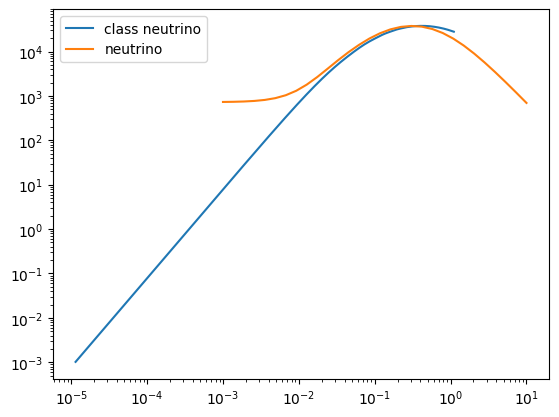

In [40]:


plt.loglog(k,-tranf["d_ncdm[0]"],label="class neutrino")
plt.loglog(kvec, -test,label="neutrino")
a = scipy.interpolate.interp1d(kvec,test)
b = scipy.interpolate.interp1d(k,tranf["d_ncdm[0]"])
klst = np.logspace(-2,0,10)
plt.legend()
#plt.figure(12)
#plt.plot(klst,a(klst)/b(klst))